Import necessary libraries


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, LabelEncoder
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras.models import *
import cv2
import skimage.io
import io
import os

Mounting Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load Image

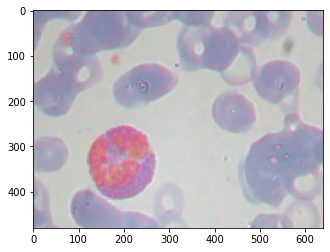

In [3]:
#load image
from google.colab.patches import cv2_imshow
images = []
img = cv2.imread('/content/drive/MyDrive/Colab Notebooks/BloodCells/dataset-master/dataset-master/JPEGImages/BloodImage_00036.jpg')
plt.imshow(img)

Convert from RGB scale to YCC scale to extract the necessary features to detect the blast

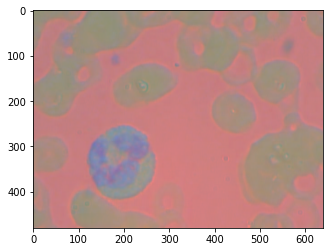

In [4]:
#RGB to YCC
imgYCC = cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)
plt.imshow(imgYCC)

In [5]:
#Plotting Y,CB,CR,Components
imgY = imgYCC[:,:,0]
imgCb = imgYCC[:,:,1]
imgCr = imgYCC[:,:,2]

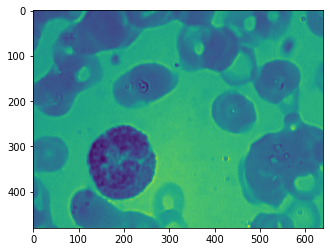

In [6]:
plt.imshow(imgY)

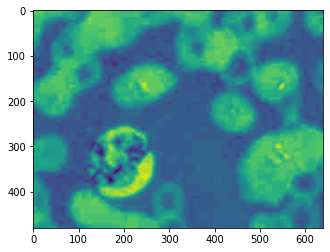

In [7]:
plt.imshow(imgCb)

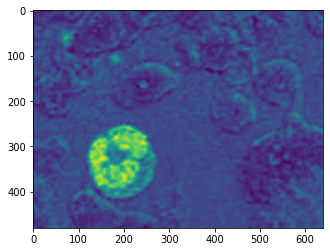

In [8]:
plt.imshow(imgCr)

In [9]:
ret1, th1 = cv2.threshold(imgYCC, 150, 255, cv2.THRESH_BINARY)

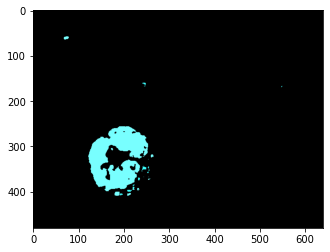

In [10]:
upper_blue = np.array([130,255,255])
lower_blue = np.array([45,255,255])
hsv1 = cv2.cvtColor(th1, cv2.COLOR_RGB2HSV)
mask = cv2.inRange(hsv1, lower_blue, upper_blue)
result = cv2.bitwise_and(hsv1, hsv1, mask=mask)
plt.imshow(result)

In [11]:
ret1, thresh1 = cv2.threshold(imgY, 0, 300, cv2.THRESH_OTSU)
ret2, thresh2 = cv2.threshold(imgCb, 128, 128, cv2.THRESH_OTSU)
ret3, thresh3 = cv2.threshold(imgCr, 128, 128, cv2.THRESH_OTSU)

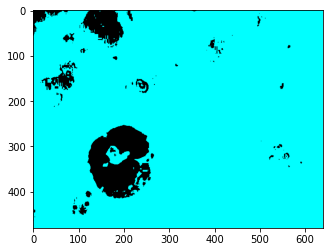

In [12]:
lower_red = np.array([0,50,50])
upper_red = np.array([10,255,255])
hsv2 = cv2.cvtColor(th1, cv2.COLOR_RGB2HSV)
mask1 = cv2.inRange(hsv2, lower_red, upper_red)
result1 = cv2.bitwise_and(hsv2, hsv2, mask=mask1)
plt.imshow(result1)

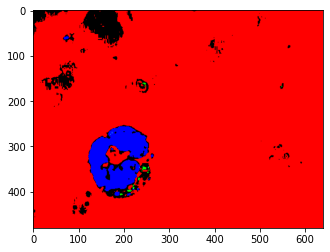

In [13]:
final_mask = mask + mask1
final_result = cv2.bitwise_and(th1, th1, mask=final_mask)
plt.imshow(final_result)

K-means algoruthm to segment cell from microscopic image

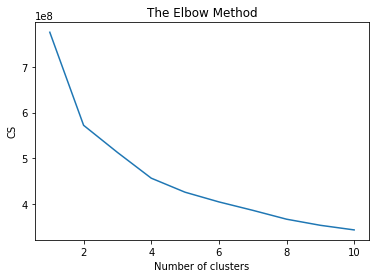

In [14]:
from sklearn.cluster import KMeans
cs = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(final_mask)
    cs.append(kmeans.inertia_)
plt.plot(range(1, 11), cs)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('CS')
plt.show()

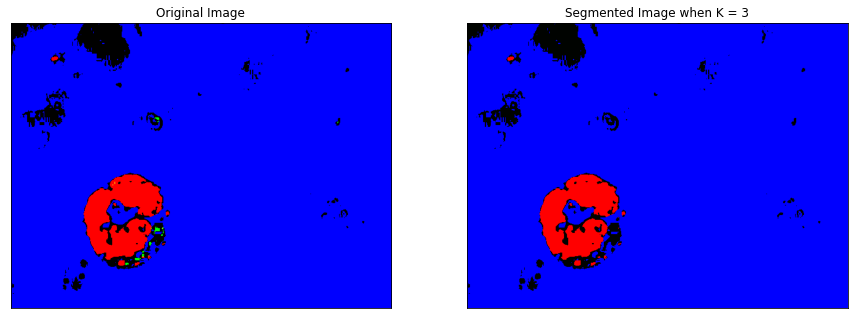

In [15]:
img=cv2.cvtColor(final_result,cv2.COLOR_RGB2BGR)
vectorized = img.reshape((-1,3))
vectorized = np.float32(vectorized)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 3
attempts = 10
ret,label,center = cv2.kmeans(vectorized,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)
center = np.uint8(center)
res = center[label.flatten()]
result_image = res.reshape((img.shape))
figure_size = 15
plt.figure(figsize = (figure_size,figure_size))
plt.subplot(1,2,1),plt.imshow(img)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2),plt.imshow(result_image)
plt.title('Segmented Image when K = %i' % K), plt.xticks([]), plt.yticks([])
plt.show()

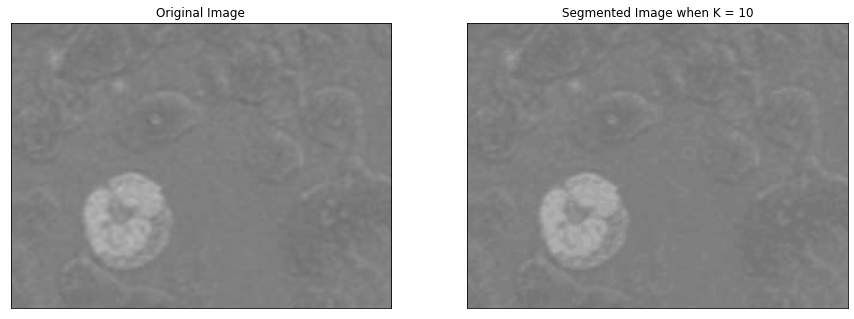

In [16]:
img=cv2.cvtColor(imgCr,cv2.COLOR_RGB2BGR)
vectorized = img.reshape((-1,3))
vectorized = np.float32(vectorized)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 10
attempts=20
ret,label,center=cv2.kmeans(vectorized,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)
center = np.uint8(center)
res = center[label.flatten()]
result_image = res.reshape((img.shape))
figure_size = 15
plt.figure(figsize=(figure_size,figure_size))
plt.subplot(1,2,1),plt.imshow(img)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2),plt.imshow(result_image)
plt.title('Segmented Image when K = %i' % K), plt.xticks([]), plt.yticks([])
plt.show()

The segemnted image is run by the classifier to detect the leukemia blast